In [27]:
import tensorflow as tf
from IPython.display import clear_output
tf.keras.utils.set_random_seed(42)
import skdim
import time
import numpy as np
import pickle
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import f1_score
import math
import matplotlib.pyplot as plt
from sklearn import datasets, manifold

### Import data and obtain the number of labels:

In [2]:
filename = 'data/dataset1.pkl'

with open(filename, 'rb') as f:
    data_tuples = pickle.load(f)
f.close()

In [24]:
print('Number of Data Points:', len(data_tuples))
class_labels = []
for i in range(len(data_tuples)):
    class_labels.append(data_tuples[i][1])

print('Class Labels:', len(set(class_labels)))
print('Feature Count:', len(data_tuples[0][0]))

Number of Data Points: 1000
Class Labels: 2
Feature Count: 200


### Perform Estimation

In [6]:
data = pd.DataFrame([i[0] for i in data_tuples])
data = (data - np.min(data)) / (np.max(data) - np.min(data))
labels = pd.DataFrame([i[1] for i in data_tuples])

In [15]:
data_0 = [i[0] for i in data_tuples if i[1] == 0]
data_1 = [i[0] for i in data_tuples if i[1] == 1]

In [25]:
for i, d in enumerate([data_0, data_1]):

    #estimate global intrinsic dimension:
    est = skdim.id.lPCA().fit(d)

    print("[{}] lPCA (PFO):".format(i), np.mean(est.dimension_))

    #estimate local intrinsic dimension (dimension in k-nearest-neighborhoods around each point):
    est = skdim.id.MOM().fit(d, n_neighbors = round(math.sqrt(len(data_tuples))), n_jobs = -1,)

    print("[{}] MOM:".format(i), np.mean(est.dimension_pw_))

[0] lPCA (PFO): 131.0
[0] MOM: 41.07058987340877
[1] lPCA (PFO): 131.0
[1] MOM: 41.608662470739745


### Visualize Data ###

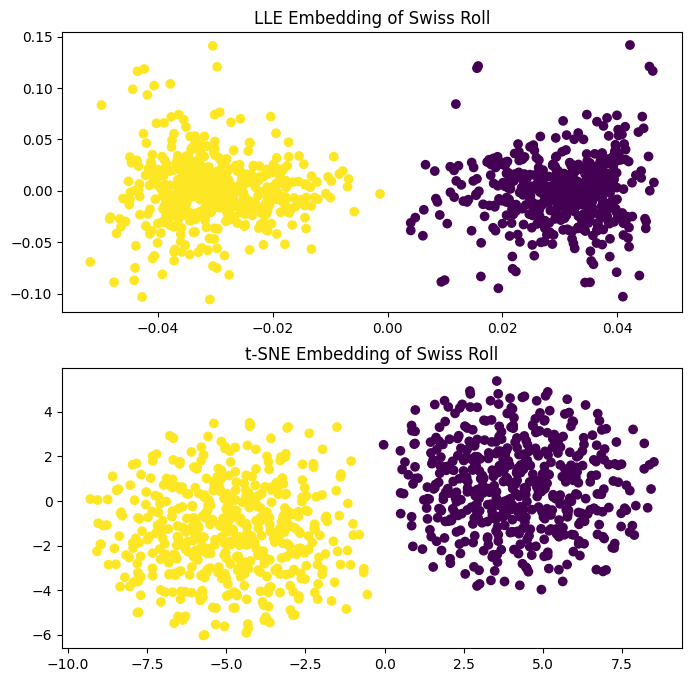

In [39]:
sr_lle, sr_err = manifold.locally_linear_embedding(
    data, n_neighbors=12, n_components=2
)

sr_tsne = manifold.TSNE(n_components=2, perplexity=40, random_state=0).fit_transform(
    data
)

fig, axs = plt.subplots(figsize=(8, 8), nrows=2)
axs[0].scatter(sr_lle[:, 0], sr_lle[:, 1], c=labels)
axs[0].set_title("LLE Embedding of Swiss Roll")
axs[1].scatter(sr_tsne[:, 0], sr_tsne[:, 1], c=labels)
_ = axs[1].set_title("t-SNE Embedding of Swiss Roll")

### Classifier ###

In [110]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42, stratify=labels)

ID = 199
shape = len(data_tuples[0][0]) # feature count

In [111]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(shape,)),
    tf.keras.layers.Dense(ID, activation='relu'),
    tf.keras.layers.Dense(1)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

start_time = time.time()

model.fit(X_train, y_train, epochs=50)

clear_output(wait=True)

print("--- %s seconds ---" % (time.time() - start_time))

--- 1.0305469036102295 seconds ---


In [112]:
test_loss, test_acc = model.evaluate(X_test,  y_test)
f1 = f1_score(y_test, [0 if x < 0 else 1 for x in model.predict(X_test)], average='weighted')

print('\nTest accuracy:', test_acc)
print('\nTest F1 (weighted):', f1)

7/7 [==============================] - 0s 500us/step

Test accuracy: 1.0

Test F1 (weighted): 1.0


### Analyze Model Weights ###

In [113]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 199)               39999     
                                                                 
 dense_7 (Dense)             (None, 1)                 200       
                                                                 
Total params: 40199 (157.03 KB)
Trainable params: 40199 (157.03 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [119]:
unused_threshold = 0.005   # used to determine if a weight is being 'unused' 

for layer in model.layers:
    
    weights = layer.get_weights()
    print("Layer Name:", layer.name)
    print("Weight #:", len(weights[0]))
    
    sorted_weights = [i[0] for i in weights[0]]
    print("Sorted Weights:", np.sort(sorted_weights))
    
    print("'Unused Weights:'", sum(1 for i in np.sort(sorted_weights) if abs(i) <= 0.005))

Layer Name: dense_6
Weight #: 200
Sorted Weights: [-0.29955614 -0.24222374 -0.23788278 -0.23245797 -0.22546844 -0.21876149
 -0.21505009 -0.20251943 -0.17492183 -0.16985632 -0.16399893 -0.16006903
 -0.15071149 -0.14972687 -0.14908272 -0.14664401 -0.14375496 -0.13032039
 -0.12996116 -0.1255283  -0.12201523 -0.11640695 -0.11572193 -0.11167745
 -0.1110695  -0.10913833 -0.10648143 -0.10415282 -0.10268454 -0.09590616
 -0.09509756 -0.09332002 -0.09174564 -0.08736069 -0.08662996 -0.08523487
 -0.0851901  -0.08182486 -0.07985296 -0.07862116 -0.07830867 -0.07669788
 -0.07578305 -0.07276186 -0.07141729 -0.0706673  -0.07006223 -0.06449901
 -0.06198011 -0.06138122 -0.06104034 -0.05992201 -0.05773416 -0.05379864
 -0.05227076 -0.05177919 -0.05138462 -0.05126195 -0.04931281 -0.04891613
 -0.04790939 -0.04758113 -0.04188775 -0.03942982 -0.03872291 -0.03328316
 -0.0331921  -0.03293424 -0.03257131 -0.03052247 -0.03049452 -0.02895164
 -0.0267897  -0.02632307 -0.02503861 -0.0186608  -0.01858154 -0.01813012
 